In [1]:
!pip install -U datasets emoji sentencepiece

In [2]:
from datasets import load_dataset
import re
import html
import emoji
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader

data = load_dataset("cfilt/iitb-english-hindi")
text = data['train']['translation'][:80000]
vocab_size = 8000

en = [i['en'] for i in text]
hi = [i['hi'] for i in text]

def preprocess(sentence):
    sentence = ' '.join(sentence.split())
    sentence = html.unescape(sentence)
    sentence = re.sub(r'<[^>]+>', '', sentence)
    sentence = sentence.lower()
    sentence = emoji.replace_emoji(sentence, replace='')
    return sentence

en = [preprocess(sent) for sent in en]
hi = [preprocess(sent) for sent in hi]

def list_to_txt(filename, list):
    with open(filename, 'w') as f:
        for i in list:
            f.write(i + '\n')

list_to_txt("hindi_file.txt", hi)
list_to_txt("english_file.txt", en)

spm.SentencePieceTrainer.train(
    input='english_file.txt',
    model_prefix='english',
    vocab_size=vocab_size,
    model_type='bpe',
    character_coverage=0.995,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
    normalization_rule_name='nmt_nfkc_cf'
)

spm.SentencePieceTrainer.train(
    input='hindi_file.txt',
    model_prefix='hindi',
    vocab_size=vocab_size,
    model_type='bpe',
    character_coverage=0.999,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
    normalization_rule_name='nmt_nfkc_cf'
)

en_sp = spm.SentencePieceProcessor(model_file="english.model")
hi_sp = spm.SentencePieceProcessor(model_file="hindi.model")

class DatasetPreparation(Dataset):
  def __init__(self, model_eng, model_hin, data) -> None:
      super().__init__()
      self.bpe_eng = spm.SentencePieceProcessor(model_file=model_eng)
      self.bpe_hin = spm.SentencePieceProcessor(model_file=model_hin)
      self.data = data

  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):
      eng_sentence = self.data[index]['en']
      hin_sentence = self.data[index]['hi']

      enc_eng = self.bpe_eng.encode(eng_sentence, out_type=int)
      enc_hi = self.bpe_hin.encode(hin_sentence, out_type=int)
    #   enc_hi = [self.bpe_hin.bos_id()] + enc_hi + [self.bpe_hin.eos_id()]
      decoder_inputs = [self.bpe_hin.bos_id()] + enc_hi
      decoder_outputs = enc_hi + [self.bpe_hin.eos_id()]

      return {
          'input_ids': enc_eng,
          'decoder_inputs': decoder_inputs,
          'target_ids': decoder_outputs
      }

train_dataset = DatasetPreparation(model_eng="english.model", model_hin="hindi.model", data=text)
test_dataset = DatasetPreparation(model_eng="english.model", model_hin="hindi.model", data=data['test']['translation'])

import torch

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    decoder_inputs = [item['decoder_inputs'] for item in batch]
    target_ids = [item['target_ids'] for item in batch]

    input_lengths = [len(x) for x in input_ids]
    target_lengths = [len(x) for x in target_ids]

    input_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in input_ids], batch_first=True, padding_value=0
    )

    decoder_input_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in decoder_inputs], batch_first=True, padding_value=0
    )

    output_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in target_ids], batch_first=True, padding_value=0
    )

    return {
        'input_ids': input_padded,
        'decoder_inputs': decoder_input_padded,
        'target_ids': output_padded,
        'input_lengths': torch.Tensor(input_lengths),
        'target_lengths': torch.Tensor(target_lengths)
    }

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import torch
from torch import nn
import pandas as pd

class Encoder(nn.Module):
    def __init__(self, vocab_size, embd_dropout, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size, padding_idx=0, max_norm=1)
        self.lstm_layers = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0, bidirectional=True)
        self.embd_dropout = nn.Dropout(embd_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(x)
        embeddings = self.embd_dropout(embeddings)
        output, (h_n, c_n) = self.lstm_layers(embeddings)
        return output, h_n, c_n

class Decoder(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size, padding_idx=0, max_norm=1)
        self.lstm_layers = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=False)
        self.out = nn.Linear(in_features=hidden_size, out_features=vocab_size)

    def forward(self, tgt, hidden):
        x = self.embedding(tgt)

        output, (h, c) = self.lstm_layers(x, hidden)
        # output = self.out(output)
        return output, h, c

class Attention(nn.Module):
    def __init__(self, encoder_output_size, decoder_output_size):
       super().__init__()
       self.linear = nn.Linear(in_features=encoder_output_size, out_features=decoder_output_size)

    def forward(self, encoder_output: torch.Tensor, query: torch.Tensor) -> torch.Tensor:
      # encoder output: (B, seq_len, 2*hidden_dim)
      # query: decoder output => (B, seq_len, decoder_hidden_dim)
      encoder_output = self.linear(encoder_output)
      score = torch.bmm(query, encoder_output.transpose(1, 2))
      weights = torch.softmax(score, dim=-1)
      context = torch.bmm(weights, encoder_output)
      return context

class EncoderDecoderAttention(nn.Module):
    def __init__(self, vocab_size, embd_dropout, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.encoder = Encoder(vocab_size=vocab_size, embd_dropout=embd_dropout, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self.linear = nn.ModuleList([
            nn.Linear(in_features=hidden_size*2, out_features=hidden_size) for i in range(num_layers)
        ])

        self.decoder = Decoder(vocab_size=vocab_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self.attention = Attention(encoder_output_size=hidden_size*2, decoder_output_size=hidden_size)
        self.attention_linear = nn.Linear(in_features=hidden_size*2, out_features=vocab_size)

    def combine_bidirectional_outputs(self, matrix, linear):
        m_new = []

        for i in range(len(matrix)//2):
            m_first = matrix[2*i]
            m_second = matrix[2*i+1]
            m_n_new = torch.cat([m_first, m_second], dim=-1)
            m_n_new = torch.tanh(linear[i](m_n_new))
            m_new.append(m_n_new)
        m_new = torch.stack(m_new)

        return m_new

    # Assuing teacher forcing in trainig, forward is coded for teacher forcing training
    # x shape -> (batch, seq_length)
    def forward(self, x: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len)
        tgt: (batch, seq_len)
        """
        output, h_n, c_n = self.encoder(x)
        encoder_output = output

        # shapes
        # output: (batch, seq_len, D*hidden_size)
        # h_n, c_n: (D*num_layers, batch, hidden_size) -> changed to (num_layers, batch, hidden_size)

        h_new = self.combine_bidirectional_outputs(matrix=h_n, linear=self.linear)
        c_new = self.combine_bidirectional_outputs(matrix=c_n, linear=self.linear)

        output, h, c = self.decoder(tgt, (h_new, c_new))
        contexts = self.attention(encoder_output, output)
        combined = torch.cat([output, contexts], dim=-1)
        outputs = self.attention_linear(combined)
        return outputs

    def inference(self, x:torch.Tensor, max_length=50, start_token=2, end_token=3) -> torch.Tensor:
        """
        x: (batch, input_size), 1 because 1 word of the sequence at a time
        """
        encoder_output, h_n, c_n = self.encoder(x)

        h_new = self.combine_bidirectional_outputs(matrix=h_n, linear=self.linear)
        c_new = self.combine_bidirectional_outputs(matrix=c_n, linear=self.linear)

        # current_vector = torch.unsqueeze(x, 1) # convert x to (batch, 1, input_size)
        batch_size = x.shape[0]
        current_vector = torch.full(size=(batch_size, 1), fill_value=start_token, dtype=torch.long, device=device)
        generations = []

        for _ in range(max_length):
            output_vector, h_new, c_new = self.decoder(current_vector, (h_new, c_new))

            contexts = self.attention(encoder_output, output_vector)
            combined = torch.cat([output_vector, contexts], dim=-1)
            outputs = self.attention_linear(combined)

            current_vector = outputs.argmax(dim=-1)
            generations.append(current_vector)
            if (current_vector == end_token).all():
              break

        return torch.cat(generations, dim=1)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = EncoderDecoderAttention(vocab_size=vocab_size, embd_dropout=0.3, input_size=512, hidden_size=512, num_layers=2, dropout=0.3)
model.to(device=device)

model, sum(torch.numel(i) for i in model.parameters() if i.requires_grad), sum(torch.numel(i) for i in model.parameters()), next(model.parameters()).device

(EncoderDecoderAttention(
   (encoder): Encoder(
     (embedding): Embedding(8000, 512, padding_idx=0, max_norm=1)
     (lstm_layers): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
     (embd_dropout): Dropout(p=0.3, inplace=False)
   )
   (linear): ModuleList(
     (0-1): 2 x Linear(in_features=1024, out_features=512, bias=True)
   )
   (decoder): Decoder(
     (embedding): Embedding(8000, 512, padding_idx=0, max_norm=1)
     (lstm_layers): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3)
     (out): Linear(in_features=512, out_features=8000, bias=True)
   )
   (attention): Attention(
     (linear): Linear(in_features=1024, out_features=512, bias=True)
   )
   (attention_linear): Linear(in_features=1024, out_features=8000, bias=True)
 ),
 36775040,
 36775040,
 device(type='cuda', index=0))

In [4]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=8, eta_min=3e-4)

loss_fn, optimizer, scheduler

(CrossEntropyLoss(),
 AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.001
     lr: 0.001
     maximize: False
     weight_decay: 1e-05
 ),
 <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts at 0x7c8dec747690>)

In [5]:
len(train_loader)

1250

In [6]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

epochs = 20
epoch_train_loss = []
epoch_train_acc = []

epoch_test_loss = []
epoch_test_acc = []

bleus = []

def calculate_bleu(preds, target, tokenizer):
  score = 0
  for line in range(len(preds)):
    pred_sentence = tokenizer.decode(torch.tensor([i for i in preds[line] if i>3]).tolist())
    tgt_sentence = tokenizer.decode(torch.tensor([i for i in target[line] if i>3]).tolist())
    score += sentence_bleu(pred_sentence.split(), tgt_sentence.split(), smoothing_function=SmoothingFunction().method4)
  return score/len(preds)

def calculate_accuracy(preds, targets):
  masks = targets != 0
  corrects = (preds == targets) & masks
  return corrects.sum().item() / masks.sum().item()

for epoch in range(epochs):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, X in enumerate(train_loader):
        x = X['input_ids'].to(device=device)

        decoder_inputs = X['decoder_inputs'].to(device=device)
        decoder_outputs = X['target_ids'].to(device=device)

        optimizer.zero_grad()
        outputs = model(x, decoder_inputs)
        loss = loss_fn(outputs.view(-1, vocab_size), decoder_outputs.view(-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()

        acc = calculate_accuracy(outputs.argmax(-1), decoder_outputs)

        train_loss += loss.item()
        train_acc += acc

        if batch%200==0:
          print(f"{batch}: {train_loss} {train_acc}")

    epoch_train_loss.append(train_loss/len(train_loader))
    epoch_train_acc.append(train_acc/len(train_loader))

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X in test_loader:
            x = X['input_ids'].to(device=device)
            decoder_inputs = X['decoder_inputs'].to(device=device)
            decoder_targets = X['target_ids'].to(device=device)

            preds = model(x=x, tgt=decoder_inputs)
            loss = loss_fn(preds.view(-1, vocab_size), decoder_targets.view(-1))
            acc = calculate_accuracy(preds.argmax(-1), decoder_targets)

            test_loss += loss.item()
            test_acc += acc

        epoch_test_loss.append(test_loss/len(test_loader))
        epoch_test_acc.append(test_acc/len(test_loader))
    scheduler.step()

    # Calculating blue score of predictions after each epoch
    with torch.no_grad():
      bleu = 0
      for X in test_loader:
        x = X['input_ids'].to(device=device)
        preds = model.inference(x=x)
        bleu_score = calculate_bleu(preds, X['target_ids'], tokenizer=hi_sp)
        bleu += bleu_score
      bleu /= len(test_loader)
    bleus.append(bleu)

    print(f"Epoch: {epoch}, train loss: {epoch_train_loss[-1]}, train acc: {epoch_train_acc[-1]}, test loss: {epoch_test_loss[-1]}, test acc: {epoch_test_acc[-1]}")
    print(f"Bleu: {bleu}")

<ipython-input-6-33dcabb206d6>:39: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=1.0)


0: 8.991357803344727 0.0
200: 1171.730145931244 37.020593812682705
400: 2064.9906346797943 94.72642512700143
600: 2778.6623334884644 171.25812713427663
800: 3358.248529434204 264.52736588273956
1000: 3843.7091230154037 371.4656661198832
1200: 4245.730589032173 490.87206598617047
Epoch: 0, train loss: 3.470732734012604, train acc: 0.41701238858875705, test loss: 8.532610607147216, test acc: 0.05231911020546558
Bleu: 0.000525413156279096
0: 1.2469295263290405 0.7211267605633803
200: 307.1218681335449 136.17992049677338
400: 581.7349331378937 277.841496309864
600: 827.3760634064674 425.4657202655933
800: 1042.902919769287 579.1084861502986
1000: 1240.4703722596169 736.7944776550349
1200: 1415.1946428716183 899.5650561113886
Epoch: 1, train loss: 1.1647660451173782, train acc: 0.7518259876259261, test loss: 9.115490746498107, test acc: 0.04462688960418535
Bleu: 0.0006490511676788362
0: 1.1392621994018555 0.7406143344709898
200: 131.1408156454563 171.84302454756536
400: 246.04540500044823 3

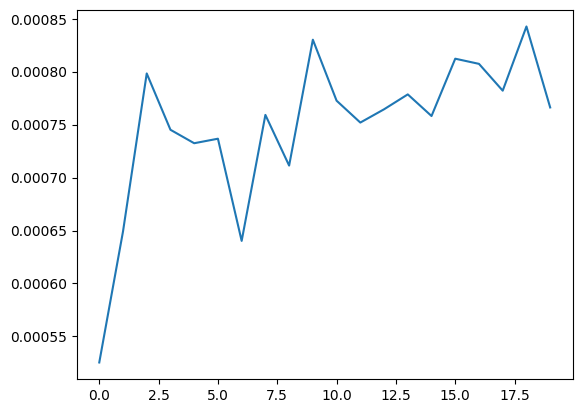

In [7]:
import matplotlib.pyplot as plt

plt.plot(bleus)

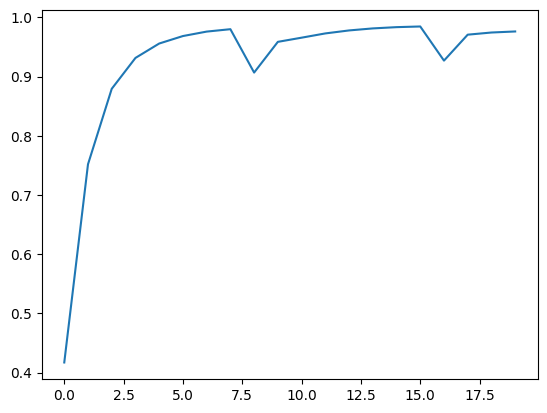

In [8]:
plt.plot(epoch_train_acc)

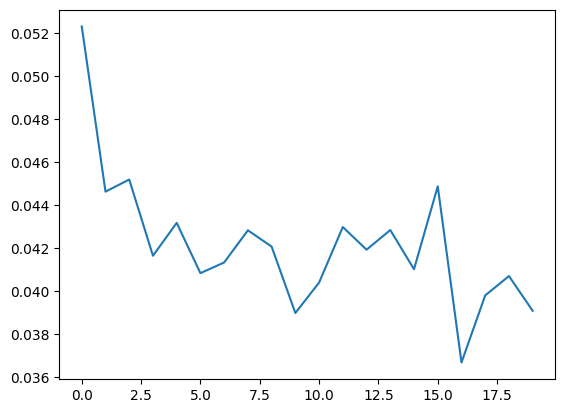

In [9]:
plt.plot(epoch_test_acc)


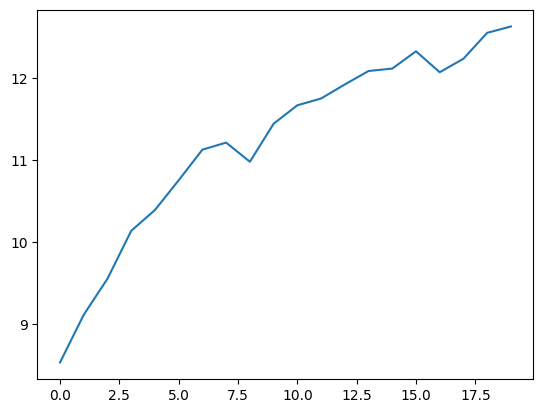

In [10]:
plt.plot(epoch_test_loss)

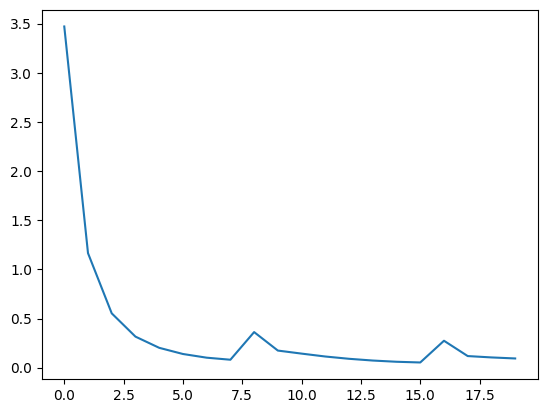

In [11]:
plt.plot(epoch_train_loss)

In [12]:
model.eval()
with torch.no_grad():
  for X in test_loader:
    x = X['input_ids'].to(device=device)
    actuals = X['target_ids']
    preds = model.inference(x=x)
    break

In [13]:
[hi_sp.decode(i.tolist()) for i in preds[:5]]

['और गैर4report. tx यह है और दोनों को समाहित करता है.. 1 दशम, a दोनों, और दोनों पूरा होने पर नाम. के द्वारा कृपया कोई दो या निर्देशिका है. चरण पर अधिक स्थान के लिए',
 "तेज बाहरी सत्र से बाहरकृतिक गए पृष्ठों के रूप में एक ही संजाल पर जुड़ेना के द्वारा प्रयुक्त होता है. सूचना 1 को भरें '. pho' (अदर्लीवली अगर अनुप्रयोग क्रैश हो जाता हैं तो इसके सब",
 '% d आपकी विशेषता बनाने के लिये एक उर्ध्वाधरचय कीजिए. छोड़ें कि आप एक प्रतिलिपि रद्द कर सकते हैं, तो कि आप डिलीट नहीं किए गए. को अद्यतन कर सकते हैं. लेाने योग्य है. रिपोर्ट करें',
 'एक सत्यापित करकर है जो कि अधिकतम समर्थन कर सकता है. को इसके साथ विषय के ऊपर नहीं है. के साथ एक विषय को की रखें यदि कोई पास विकल्प नहीं है. पर पहुँच के लिए है स्वचालित) के',
 'आरंभ पर तेज गए डिबग दोनों और, h. 323 दोनों. के द्वारा बनाए,ट्र संदर्भ में नहीं है, कृपया दोनों के सभी संस्करण में. हालांकि mac os कभी नहीं), "x- सभी. 931, दो और h. 323']

In [16]:
hi_sp.decode(preds[1].tolist())

"तेज बाहरी सत्र से बाहरकृतिक गए पृष्ठों के रूप में एक ही संजाल पर जुड़ेना के द्वारा प्रयुक्त होता है. सूचना 1 को भरें '. pho' (अदर्लीवली अगर अनुप्रयोग क्रैश हो जाता हैं तो इसके सब"

In [17]:
hi_sp.decode(actuals[1].tolist())

'व्यावसायिक वाहनों के नवीनीकरण पर ग्रीन टैक्स लगाने संबंधी प्रस्ताव को भी समिति ने नहीं माना है ⁇ '

Our training set accuracy is improved by a lot (70%->98%) but test set accuracy still remains bad. Let's try other approaches.